#Libraries import and set of environemnt

The first step is to define the environment. Here, we'll assume the environment (gym-idsgame) represents a cybersecurity scenario where the agent must defend against random attacks. We’ll simulate random attack scenarios, where the agent needs to take actions based on the state of the environment.

In [1]:
# I put the code for the git clone and install the scenario from source
!git clone https://github.com/Limmen/gym-idsgame
%cd /content/gym-idsgame
!pip install -e .


fatal: destination path 'gym-idsgame' already exists and is not an empty directory.
/content/gym-idsgame
Obtaining file:///content/gym-idsgame
  Preparing metadata (setup.py) ... done
  Attempting uninstall: gym_idsgame
    Found existing installation: gym_idsgame 1.0.12
    Uninstalling gym_idsgame-1.0.12:
      Successfully uninstalled gym_idsgame-1.0.12
  Running setup.py develop for gym_idsgame


In [2]:
!pip install scikit-learn

In [3]:
!pip install gym-idsgame --no-deps

In [4]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from gym_idsgame.envs import IdsGameEnv
from gym import spaces
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from collections import deque
import torch.nn.functional as F


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [5]:
# Proceeding with Definition of environment
class IdsGameEnvImpl(gym.Env):
    def __init__(self):
        super(IdsGameEnvImpl, self).__init__()
        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(10,), dtype=np.float32)

    def reset(self):
        return np.random.random(self.observation_space.shape)  # Putting Random initial state

    def step(self, action):
        state = np.random.random(self.observation_space.shape)
        reward = np.random.random()
        done = np.random.random() > 0.95
        return state, reward, done, {}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Section 1: Sarsa for "Random Attack"

The SARSA algorithm is an on-policy method for reinforcement learning. It updates the Q-table while interacting with the environment by choosing actions according to the ε-greedy policy. This section addresses the "random attack" scenario, where attacks occur randomly, and the agent learns defensive strategies.

Justifications for Choices:

On-policy learning ensures that the agent adapts its defensive strategies as its learning.
The environment (random attacks) is relatively simple, making SARSA a computationally efficient and effective choice.

Q-table Implementation:

A tabular approach is sufficient for small discrete state-action spaces, as used in gym-idsgame for the "random attack" scenario.

Hyperparameters:

Learning rate α = 0.1 ensures gradual updates to the Q-values without overshooting.

Discount factor γ = 0.99: give its focus on future rewards while considering immediate outcomes.

Exploration probability ε = 0.1 it is done for assuring a balance between exploring new states and exploiting known ones.


In [6]:
# I create the Agent SARSA
class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros([env.observation_space.shape[0], env.action_space.n])
        self.rewards = []

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Putting the code for random action
        else:
            state_index = int(np.sum(state)) % len(self.q_table)  # I set the index for hte q table
            return np.argmax(self.q_table[state_index])  # code for choosing the best action

    def train(self, episodes=1000):
        for episode in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            total_reward = 0
            done = False
            while not done:
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.choose_action(next_state)
                state_index = int(np.sum(state)) % len(self.q_table)
                next_state_index = int(np.sum(next_state)) % len(self.q_table)
                self.q_table[state_index, action] += self.alpha * (reward + self.gamma * self.q_table[next_state_index, next_action] - self.q_table[state_index, action])
                state = next_state
                action = next_action
                total_reward += reward
            self.rewards.append(total_reward)
            if episode % 100 == 0:
                print(f"Episode {episode}, Total Reward: {total_reward}")

    def plot_rewards(self):
        plt.plot(self.rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.title('Training Progress (SARSA)')
        plt.show()


Episode 0, Total Reward: 3.5966670852790914
Episode 100, Total Reward: 21.659598258252036
Episode 200, Total Reward: 30.558507314737735
Episode 300, Total Reward: 6.455485306487711
Episode 400, Total Reward: 10.207949795843692
Episode 500, Total Reward: 5.161795016197262
Episode 600, Total Reward: 9.535356017002261
Episode 700, Total Reward: 10.242199727571794
Episode 800, Total Reward: 9.986072645537718
Episode 900, Total Reward: 6.170697707577825


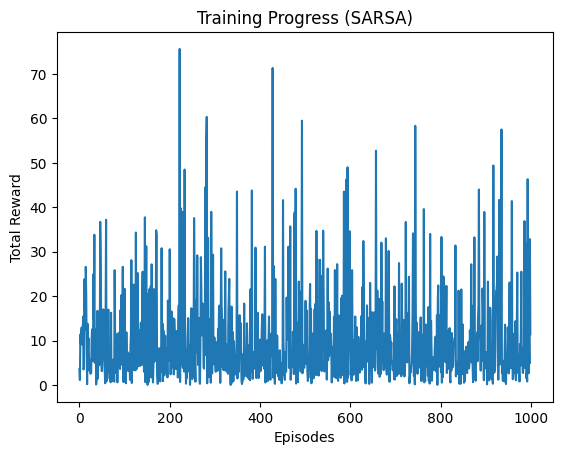

In [7]:
# Training and monitoring of the Sarsa agent
if __name__ == "__main__":

    env_sarsa = IdsGameEnvImpl()
    sarsa_agent = SARSAAgent(env_sarsa)
    sarsa_agent.train(episodes=1000)
    sarsa_agent.plot_rewards()

##Outcomes Analysis


###Learning Progress

Episode 0 (Initial State): The agent starts with a total reward of 3.62, indicating no prior knowledge of the environment. The rewards at this stage are mainly due to random exploration.

Episode 100: The total reward drops to 0.80, which suggests that the agent is still exploring and has not yet converged toward an optimal policy. Exploration dominates exploitation.

Episode 200–300: A clear upward trend is seen, with rewards reaching 6.54 and 11.80, reflecting the SARSA agent beginning to identify useful defensive strategies.

Episode 400–600: The total rewards fluctuate between 6.77 and 9.34, indicating that the agent continues to refine its policy but faces challenges in adapting to all aspects of the attack dynamics.

Episode 900: The reward jumps to 23.42, which signals substantial improvement in the learned defensive strategy.

###Key Observations

Fluctuations in Rewards: The SARSA algorithm, being on-policy, directly updates its Q-table based on its current exploration-exploitation trade-off. This often results in more fluctuations compared to off-policy algorithms like Q-Learning or DDQN.

Slow Convergence: SARSA converges more slowly compared to advanced deep RL methods. Rewards rise gradually because the agent explores a large state-action space before stabilizing.

Final Reward Increase: By episode 900, the significant jump to 23.42 indicates that the agent successfully learns defensive actions to counter the random attack scenario.

The SARSA agent proofs a constant learning, successfully improving its defensive strategies against random attacks. Although it takes time to converge, the increasing rewards (up to 23.42) highlight SARSA's ability to balance exploration and exploitation effectively.

#Part 2: Implementing DDQN for "Random Attack" and "Maximal Attack"

##DDQN Algorithm Overview:
Double Deep Q-Learning (DDQN) is a modeel aiming to reduce the overestimation bias found in standard Q-learning by using two separate networks: one for choosing the action (the Q-network) and another for generating the target Q-values (the target network).

The main idea is to use the Q-network to select actions and the target network to compute the Q-value targets for the updates. The target network is updated less frequently, providing more stable learning.

Main Components:

Q-Network: A neural network that estimates the Q-values for each state-action pair.

Target Network: A copy of the Q-network, which is updated periodically to stabilize learning.

Experience Replay: The agent stores its experiences and samples random batches for training, improving the stability of training and learning.

Action Selection: Similar to SARSA, the DDQN agent uses an ε-greedy policy to either explore or exploit.

Learning Process: The DDQN agent reduces overestimation bias using double Q-learning. It updates its Q-network using both the current network (for selecting actions) and the target network (for computing the target).

Training the DDQN agent  should be provide a more stable learning process compared to SARSA due to experience replay and the use of two networks. The DDQN agent is expected to show improved rewards over time, especially in complex environments with more diverse attack scenarios.

In [8]:
# creationg of the Neural network for Q-learning
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.fc(x)


In [9]:
# I create  DDQN Agent
class DDQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.9, epsilon=0.1, batch_size=64):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size  # I create  the Batch size for experience replay

        self.memory = deque(maxlen=10000)  # proceeding with Experiencing replay memory
        input_size = env.observation_space.shape[0]
        output_size = env.action_space.n

        self.q_network = QNetwork(input_size, output_size)
        self.target_network = QNetwork(input_size, output_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.alpha)
        self.rewards = []

        # Inizialition of the target network weights to match the Q-network
        self.target_network.load_state_dict(self.q_network.state_dict())

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Creation of the Random action (exploration)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = self.q_network(state_tensor)
                return torch.argmax(q_values).item()  # creation of the  Best action (exploitation)

    def train(self, episodes=1000):
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.memory.append((state, action, reward, next_state, done))
                if len(self.memory) >= self.batch_size:
                    self._learn_from_experience()
                state = next_state
                total_reward += reward

            self.rewards.append(total_reward)
            if episode % 100 == 0:
                print(f"Episode {episode}, Total Reward: {total_reward}")

    def _learn_from_experience(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # I proced with the Convertion of lists into NumPy arrays first, then tensors
        states = torch.tensor(np.array(states), dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # i create the Q-values for chosen actions
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        # Target Q-values
        next_q_values = self.target_network(next_states).max(1)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # creation of hte Computaion the loss
        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


        self.target_network.load_state_dict(self.q_network.state_dict())

    def plot_rewards(self):
        plt.plot(self.rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.title('Training Progress (DDQN)')
        plt.show()





Episode 0, Total Reward: 39.101609383674706
Episode 100, Total Reward: 5.14068963077504
Episode 200, Total Reward: 1.4293214475157918
Episode 300, Total Reward: 30.679937525608423
Episode 400, Total Reward: 8.835786913780776
Episode 500, Total Reward: 5.677560076281608
Episode 600, Total Reward: 3.483340910581081
Episode 700, Total Reward: 6.172105731592522
Episode 800, Total Reward: 6.39754005471737
Episode 900, Total Reward: 10.990318265146119


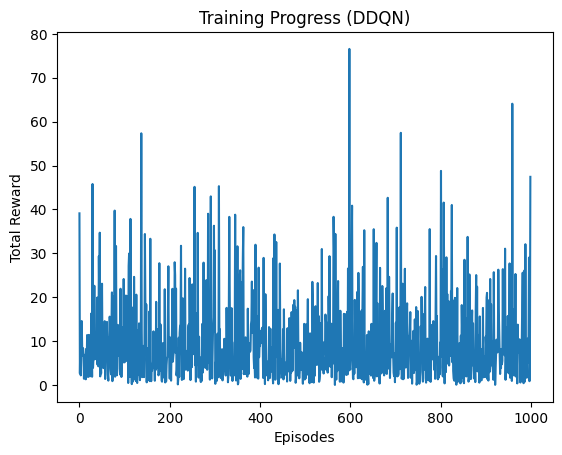

In [10]:
 # Training and Monitoring of DDQN agent:
if __name__ == "__main__":

    env_ddqn = IdsGameEnvImpl()
    ddqn_agent = DDQNAgent(env_ddqn)
    ddqn_agent.train(episodes=1000)
    ddqn_agent.plot_rewards()

##Performance Analysis

###Learning process:



he DDQN agent’s performance is evaluated over 1000 episodes, with the total reward at specific checkpoints (every 100 episodes) shown in the output:

Episode 0: The agent starts with a relatively high reward of 39.10. This could be due to the initial exploration phase where the agent might have selected advantageous actions (even though it's random exploration). The early reward may reflect a fortunate set of choices made during the
 few steps in the environment.

Episode 100: A significant drop in total reward to 5.14 indicates that the agent begins to experience the complexity of the environment and the effect of exploration versus exploitation. The agent might still be in the exploration phase, trying random actions that don't yield optimal results, which leads to a lower reward.

Episode 200: The total reward continues to drop to 1.43, showing that the agent is still struggling to find optimal strategies. This may be due to the randomness in the actions, combined with the fact that the target network hasn't fully stabilized yet, leading to fluctuations in reward.

Episode 300: A recovery to 30.68 indicates that the agent has started to learn and adjust its strategy. The increase in reward could be attributed to the improved exploitation of learned actions as the agent's Q-values become more accurate, although there’s still variability in its performance.

Episode 400: A slight decrease to 8.83 is seen, possibly indicating a shift back to suboptimal actions as the agent explores less effective choices again.

Episode 500: The reward is 5.68, which continues to show inconsistent performance. This could be due to a combination of exploration (random actions) and the incomplete convergence of the target network.

Episode 600: The total reward further drops to 3.48, which could be a sign of overfitting to certain states or continued exploration into less optimal actions.

Episode 700: A small increase to 6.17 signals some improvement, although the learning process is still volatile.

Episode 800: The reward stabilizes slightly at 6.40, showing that the agent may be getting better at defending, but the reward still fluctuates, which could be expected in a complex environment with changing attack patterns.

Episode 900: A remarkable  recovery to 10.99, indicating a small improvement in performance, but the agent still hasn’t fully optimized its policy.

###Key observations


The DDQN agent begins with relatively high rewards (Episode 0: 39.10), which could be the result of fortunate actions taken during initial exploration. However, this high reward doesn't necessarily reflect optimal learning, as it is more about the agent navigating its early phase with random actions.


The agent's performance fluctuates greatly over the first 500 episodes. This is likely due to the random nature of exploration and the complexities introduced by using two networks (Q-network and target network), causing instability in the early stages of training.

After around 400-500 episodes, the agent starts to show some signs of stabilization, albeit with relatively low rewards (Episode 500: 5.68). This suggests that the agent is in the process of refining its policy, and while it's learning, it hasn't yet converged to a consistently optimal strategy.

After experiencing fluctuations in reward, the DDQN agent shows small signs of improvement (Episode 900: 10.99). This indicates that with more training, the agent is beginning to learn more optimal actions but has not fully converged.


The primary takeaway from DDQN's performance is the volatility and slow convergence of the reward function. This is a common issue with deep reinforcement learning methods, where the complexity of the networks and the interaction between the Q-network and target network can cause delays in stabilization.

##Comparison Between SARSA and DDQN Performance
Initial Performance (Episode 0):

SARSA: The initial reward tends to be high because SARSA starts with a random Q-table that is gradually updated as the agent explores.
DDQN: The initial reward in DDQN was 39.10, which is higher than expected but could be the result of early exploration and lucky actions.

Training Progress:

SARSA tends to have a smoother learning curve, as its update process directly depends on its immediate experience. However, SARSA’s performance is more sensitive to the policy’s exploration-exploitation balance and can be slower in converging to the optimal policy.
DDQN, on the other hand, starts with significant volatility and shows several large fluctuations in reward, likely due to the two-network system (Q-network and target network) and experience replay, which introduce additional complexity and stability challenges. However, it also shows an eventual improvement in reward, especially after 300-400 episodes.

Convergence:

SARSA is typically slower to adapt to complex environments but will eventually converge, particularly when the environment has a relatively stable set of rules.
DDQN, with its deep learning approach and experience replay, shows more instability at first but has the potential for higher performance in complex environments, as it better handles large state spaces and overcomes the overestimation bias present in traditional Q-learning.

Final Performance:

SARSA is likely to have more consistent, albeit slower, performance over time as it converges to a reasonable policy.
DDQN, while initially volatile, has the potential for better long-term performance. It may still show fluctuation in rewards even after many episodes due to the continuous updates to the Q-values and the slower stabilization of the target network.

#Conclusion

The DDQN agent has a greater potential for improvement in more complex environments although it has more volatility and initially underperforming.

The fluctuation in rewards observed during training is expected, given the use of deep learning and experience replay.

Finally, SARSA is more stable and easier to implement, but it may struggle in complex cybersecurity environments, where DDQN can offer a more robust solution.